# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from collections import deque

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [2]:
data = pd.read_csv('bankAuth.txt', header=None)

In [3]:
# your code here
data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data

,variance,skewness,curtosis,entropy,class
0,1.00000,2.00000,3.0000,4.00000,5
1,3.62160,8.66610,-2.8073,-0.44699,0
2,4.54590,8.16740,-2.4586,-1.46210,0
3,3.86600,-2.63830,1.9242,0.10645,0
4,3.45660,9.52280,-4.0112,-3.59440,0
...,...,...,...,...,...
1368,0.40614,1.34920,-1.4501,-0.55949,1
1369,-1.38870,-4.87730,6.4774,0.34179,1
1370,-3.75030,-13.45860,17.5932,-2.77710,1
1371,-3.56370,-8.38270,12.3930,-1.28230,1


In [4]:
# analyse the data
data.describe()
data.isnull().sum() # no null values
data.shape

(1373, 5)

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [5]:
# your code here

# get X,y for the split
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Splitting the data in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Convert data into numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [6]:
# your code here

# Gini Index
def gini_index(y):
    # get the unique classes
    classes = np.unique(y)
    # calculate gini index
    gini = 1.0
    for c in classes:
        # count the number of samples for each class
        count = np.sum(y == c)
        # calculate the proportion of samples for each class
        proportion = count / len(y)
        # calculate gini
        gini -= proportion * proportion

    return gini

# Entropy
def entropy(y):
    # get the unique classes
    classes = np.unique(y)
    # calculate entropy
    entropy = 0.0
    for c in classes:
        # count the number of samples for each class
        count = np.sum(y == c)
        # calculate the proportion of samples for each class
        proportion = count / len(y)
        # calculate entropy
        entropy -= proportion * np.log2(proportion)

    return entropy

# Misclassification Error
def misclassification_error(y):
    # get the unique classes
    classes = np.unique(y)
    # calculate misclassification error
    misclass = 1.0
    for c in classes:
        # count the number of samples for each class
        count = np.sum(y == c)
        # calculate the proportion of samples for each class
        proportion = count / len(y)
        # calculate misclassification error
        misclass = min(misclass, proportion)

    return misclass

# Log Loss
def log_loss(y):
    # get the unique classes
    classes = np.unique(y)
    # calculate log loss
    logloss = 0.0
    for c in classes:
        # count the number of samples for each class
        count = np.sum(y == c)
        # calculate the proportion of samples for each class
        proportion = count / len(y)
        # calculate log loss
        logloss -= proportion * np.log(proportion)

    return logloss


### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [7]:
# your code here

# Node Class
class Node:
    def __init__(self, feature_idx = None, threshold = None, left = None, right = None, info_gain = None, entropy = None, value = None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # for leaf nodes
        self.entropy = entropy
        self.value = value
    
# Decision Tree Class
class DecisionTreeC:
    def __init__(self, min_samples_split = 2, max_depth = 3, criterion = 'gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        # build the tree
        self.root = self.build_tree(X, y)

    def calculate_leaf_value(self, y):
        # get the unique classes
        classes, counts = np.unique(y, return_counts=True)
        # get the index of the most common class
        index = counts.argmax()
        # return the most common class
        return classes[index]
    
    def information_gain(self, y, y_left, y_right, criterion):
        # get the total entropy
        if(criterion == 'gini'):
            total_entropy = gini_index(y)
        elif(criterion == 'entropy'):
            total_entropy = entropy(y)
        elif(criterion == 'logloss'):
            total_entropy = log_loss(y)

        elif(criterion == 'mse'):
            total_entropy = misclassification_error(y)
        # get the proportion of samples in the left node
        p = len(y_left) / len(y)

        # get left and right entropies
        if(criterion == 'gini'):
            left_entropy = gini_index(y_left)
            right_entropy = gini_index(y_right)
        elif(criterion == 'entropy'):
            left_entropy = entropy(y_left)
            right_entropy = entropy(y_right)
        elif(criterion == 'logloss'):
            left_entropy = log_loss(y_left)
            right_entropy = log_loss(y_right)
        elif(criterion == 'mse'):
            left_entropy = misclassification_error(y_left)
            right_entropy = misclassification_error(y_right)
        
        # calculate the weighted entropy
        weighted_entropy = p * left_entropy + (1 - p) * right_entropy
        # calculate the information gain
        info_gain = total_entropy - weighted_entropy

        return info_gain
    
    def split(self, X, y, feature_idx, threshold):
        # get the samples where the feature value is below the threshold
        X_left = X[X[:, feature_idx] < threshold]
        y_left = y[X[:, feature_idx] < threshold]
        # get the samples where the feature value is above the threshold
        X_right = X[X[:, feature_idx] >= threshold]
        y_right = y[X[:, feature_idx] >= threshold]

        # print('X_left: ', X_left.shape)
        # print('y_left: ', y_left.shape)

        return X_left, X_right, y_left, y_right

    def get_best_split(self, X, y):
        num_samples, num_features = np.shape(X)
        best_split = {}
        best_split['feature_idx'] = None
        best_split['threshold'] = None
        best_split['info_gain'] = -1
        best_split['left'] = None
        best_split['right'] = None

        # loop over all possible thresholds
        for feature_idx in range(num_features):
            feature_values = np.unique(X[:, feature_idx])
            for threshold in feature_values:
                # split the data
                X_left, X_right, y_left, y_right = self.split(X, y, feature_idx, threshold)
                # skip if the split is not valid
                if len(X_left) == 0 or len(X_right) == 0:
                    continue

                # calculate the information gain
                info_gain = self.information_gain(y, y_left, y_right, self.criterion)

                # check if the information gain is the best
                if info_gain > best_split['info_gain']:
                    best_split['feature_idx'] = feature_idx
                    best_split['threshold'] = threshold
                    best_split['info_gain'] = info_gain
                    best_split['left'] = (X_left, y_left)
                    best_split['right'] = (X_right, y_right)
        
        return best_split

    def build_tree(self, X, y, depth = 0):
        # get the number of samples and features
        n_samples, n_features = np.shape(X)

        # split untill stopping criteria is met
        if n_samples >= self.min_samples_split and depth < self.max_depth:
            # get the best feature and threshold
            best_split = self.get_best_split(X, y)

            # check if inofrmation gain is positive
            if best_split['info_gain'] > 0:
                # split the data
                X_left, X_right, y_left, y_right = best_split['left'][0], best_split['right'][0], best_split['left'][1], best_split['right'][1]
                # print('X_left: ', X_left.shape)
                # print('y_left: ', y_left.shape)

                # build the left and right subtrees
                left = self.build_tree(X_left, y_left, depth + 1)
                right = self.build_tree(X_right, y_right, depth + 1)
                # return the node
                return Node(feature_idx = best_split['feature_idx'], threshold = best_split['threshold'], left = left, right = right, info_gain = best_split['info_gain'])
            
        # calculate the leaf value
        # leaf_value = 8
        leaf_value = self.calculate_leaf_value(y)

        # calculate entropy at leaf node
        # leaf_entropy = 5
        if(self.criterion == 'gini'):
            leaf_entropy = gini_index(y)
        elif(self.criterion == 'entropy'):
            leaf_entropy = entropy(y)
        elif(self.criterion == 'logloss'):
            leaf_entropy = log_loss(y)
        
        elif(self.criterion == 'mse'):
            leaf_entropy = misclassification_error(y)
        return Node(value = leaf_value, entropy = leaf_entropy)
    
    def make_prediction(self, node, X):
        # check if the node is a leaf node
        if node.value is not None:
            return node.value

        # get the feature value
        feature_value = X[node.feature_idx]

        # check if the feature value is less than the threshold
        if feature_value < node.threshold:
            return self.make_prediction(node.left, X)
        else:
            return self.make_prediction(node.right, X)

    def predict(self, X):
        # get the number of samples
        n_samples = X.shape[0]
        # store the predictions
        y_pred = np.empty(n_samples)
        # make predictions
        for i in range(n_samples):
            y_pred[i] = self.make_prediction(self.root, X[i])

        return y_pred
    
    def tree_info(self):
        node = self.root
        queue = deque([node])
        thresholds = []
        while queue:
            node = queue.popleft()
            if node.value is None:
                thresholds.append(node.threshold)
            
            if node.left is not None:
                queue.append(node.left)
            if node.right is not None:
                queue.append(node.right)
        return thresholds
    
    def total_nodes(self):
        # return the total number of nodes
        node = self.root
        queue = deque([node])
        total_nodes = 0
        while queue:
            node = queue.popleft()
            total_nodes += 1
            if node.left is not None:
                queue.append(node.left)
            if node.right is not None:
                queue.append(node.right)
        
        return total_nodes
    
    def print_tree(self):
        node = self.root
        queue = deque([node])
        while queue:
            node = queue.popleft()
            if node.value is None:
                print('Feature: ', node.feature_idx)
                print('Threshold: ', node.threshold)
                print('Info Gain: ', node.info_gain)
                print('Left: ', node.left.feature_idx)
                print('Right: ', node.right.feature_idx)
                # print('Value: ', node.value)
                # print('Entropy: ', node.entropy)
                print('-----------------')
            else:
                print('Label: ', node.value)
                # print('Feature: ', node.feature_idx)
                print('Entropy: ', node.entropy)
                print('-----------------')

            if node.left is not None:
                queue.append(node.left)
            if node.right is not None:
                queue.append(node.right)



In [19]:
classifier = DecisionTreeC(criterion = 'entropy')
classifier.fit(X_train, y_train)
# thresholds = classifier.tree_info()

# total_nodes = classifier.total_nodes()
# print('Total Nodes: ', total_nodes)

classifier.print_tree()




Feature:  0
Threshold:  0.3223
Info Gain:  0.40659961383045395
Left:  1
Right:  0
-----------------
Feature:  1
Threshold:  5.8974
Info Gain:  0.2907007347185093
Left:  2
Right:  0
-----------------
Feature:  0
Threshold:  1.7452
Info Gain:  0.15735422189466136
Left:  2
Right:  2
-----------------
Feature:  2
Threshold:  6.8681
Info Gain:  0.072191044150865
Left:  None
Right:  None
-----------------
Feature:  0
Threshold:  -2.7419
Info Gain:  0.8168551228991958
Left:  None
Right:  None
-----------------
Feature:  2
Threshold:  -2.2718
Info Gain:  0.5153268367872255
Left:  None
Right:  None
-----------------
Feature:  2
Threshold:  -4.8003
Info Gain:  0.028979530741456025
Left:  None
Right:  None
-----------------
Label:  1
Entropy:  0.03278881304820581
-----------------
Label:  1
Entropy:  0.6292492238560345
-----------------
Label:  1
Entropy:  0.19590927087360493
-----------------
Label:  0
Entropy:  0.0
-----------------
Label:  1
Entropy:  0.3227569588973982
-----------------
Label

In [9]:
# Train Accuracy
y_pred = classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print('Train Accuracy: ', accuracy)

# Test Accuracy
y_pred = classifier.predict(X_test)
# print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy: ', accuracy)

Train Accuracy:  0.941712204007286
Test Accuracy:  0.9236363636363636


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [10]:
def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

# 1

DecisionTreeClassifier is used for classification problems where our target is to classify an entry into a particular class. DecisionTreeRegressor is used for regression problems where our target is to assign a value to an entry based on the features.

In our case, we just need to predict which of the 2 classes (forged and authentic) a particular banknote belongs to. Hence, we use DecisionTreeClassifier.

In order to use DecisionTreeRegressor, we have to change the values in the last column (class) from binary values to continious values in a range: like we can have the last column to denote the authenticity score. 

In [11]:
# 2

## Fit Decision Tree Classifier
clf_normal = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_normal.fit(X_train, y_train)
## Get train accuracy
y_pred_train = clf_normal.predict(X_train)
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
## Get test accuracy
y_pred_test = clf_normal.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))

Train Accuracy:  0.9653916211293261
Test Accuracy:  0.9345454545454546


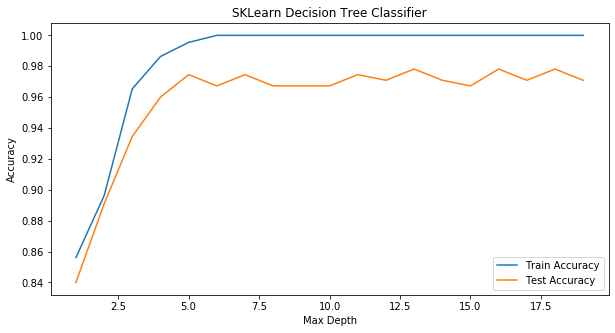

In [12]:
# Variation over max_depth
max_depths = np.arange(1, 20)
train_acc = []  
test_acc = []
for max_depth in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_acc, label='Train Accuracy')
plt.plot(max_depths, test_acc, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SKLearn Decision Tree Classifier')
plt.show()

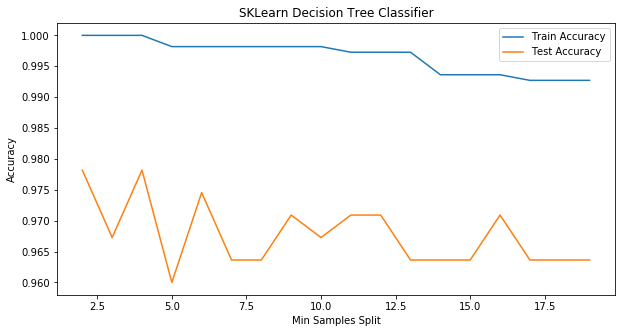

In [13]:
# Variation over min_samples_split
min_samples_splits = np.arange(2, 20)
train_acc = []
test_acc = []
for min_samples_split in min_samples_splits:
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(min_samples_splits, train_acc, label='Train Accuracy')
plt.plot(min_samples_splits, test_acc, label='Test Accuracy')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SKLearn Decision Tree Classifier')
plt.show()

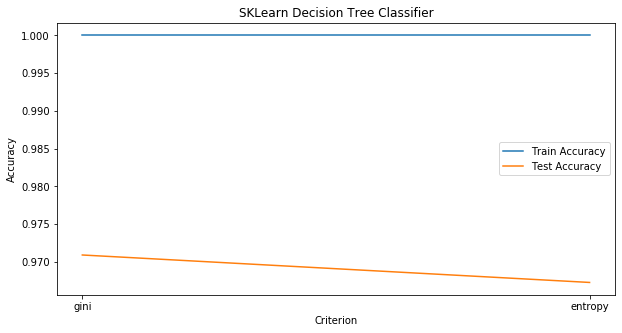

In [14]:
# Variation over criterion
criterions = ['gini', 'entropy']
train_acc = []
test_acc = []
for criterion in criterions:
    clf = DecisionTreeClassifier(criterion=criterion)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(criterions, train_acc, label='Train Accuracy')
plt.plot(criterions, test_acc, label='Test Accuracy')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SKLearn Decision Tree Classifier')
plt.show()

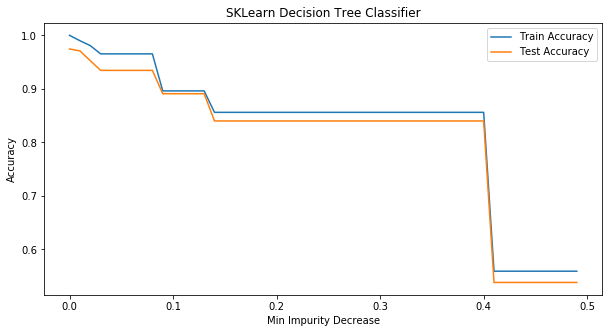

In [15]:
# Variation over min_impurity_decrease
min_impurity_decreases = np.arange(0, 0.5, 0.01)
train_acc = []
test_acc = []
for min_impurity_decrease in min_impurity_decreases:
    clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=min_impurity_decrease)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(min_impurity_decreases, train_acc, label='Train Accuracy')
plt.plot(min_impurity_decreases, test_acc, label='Test Accuracy')
plt.xlabel('Min Impurity Decrease')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SKLearn Decision Tree Classifier')
plt.show()

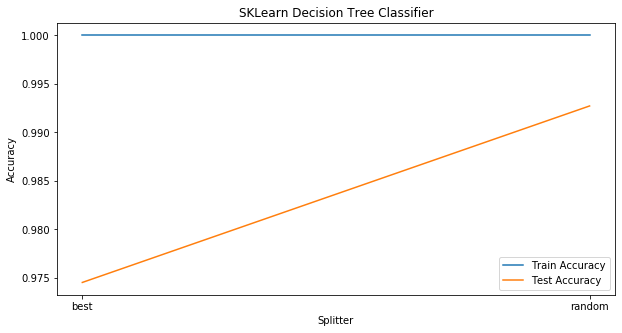

In [16]:
# Variation over splitter
splitters = ['best', 'random']
train_acc = []
test_acc = []
for splitter in splitters:
    clf = DecisionTreeClassifier(criterion='entropy', splitter=splitter)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(splitters, train_acc, label='Train Accuracy')
plt.plot(splitters, test_acc, label='Test Accuracy')
plt.xlabel('Splitter')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SKLearn Decision Tree Classifier')
plt.show()

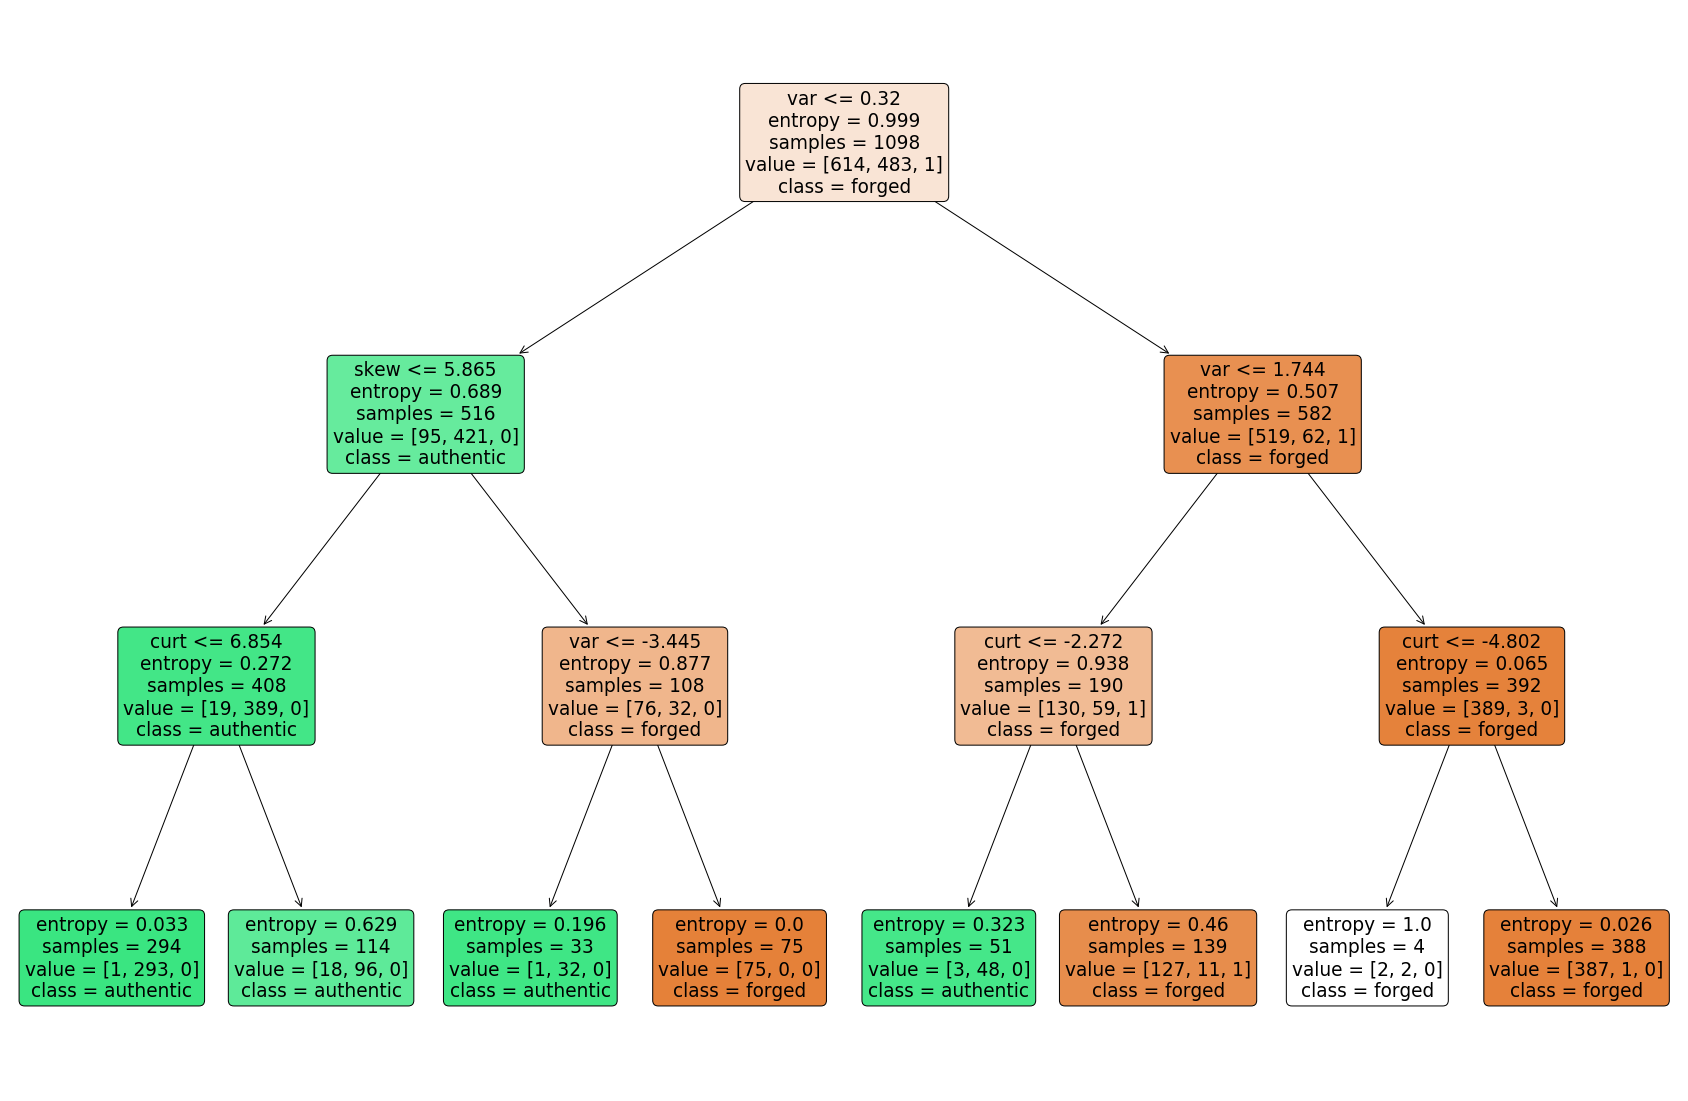

In [17]:
# 3

# Plot tree for clf_normal
plotTree(clf_normal)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

In [18]:
# your code here